<a href="https://colab.research.google.com/github/ritwiks9635/My_Neural_Network_Architecture/blob/main/Reading_Captcha_Using_OCR_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐

In [ ]:
import cv2
import glob
import numpy as np
import pandas as pd
from pathlib import Path
import tensorflow as tf
from collections import Counter
import matplotlib.pyplot as plt

In [ ]:
seed = 1234
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
data_dir = Path("/content/samples/")
#data_dir
print(len(os.listdir(data_dir)))
images = list(data_dir.glob("*.png"))
print(len(images))

1071
1040


Shape of image:  (50, 200, 3)
Shape of image:  (50, 200, 3)
Shape of image:  (50, 200, 3)
Shape of image:  (50, 200, 3)


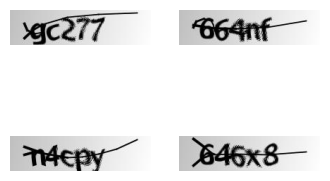

In [ ]:
img_s = images[:4]
_, ax = plt.subplots(2,2, figsize = (4,3))
for i in range(4):
    img = cv2.imread(str(img_s[i]))
    print("Shape of image: ", img.shape)
    ax[i//2, i%2].imshow(img)
    ax[i//2, i%2].axis('off')
plt.show()

In [ ]:
characters = set()

captcha_length = []

dataset = []


for img_path in images:
    label = img_path.name.split(".png")[0]
    captcha_length.append(len(label))
    dataset.append((str(img_path), label))
    for ch in label:
        characters.add(ch)


characters = sorted(characters)

dataset = pd.DataFrame(dataset, columns=["img_path", "label"], index=None)

dataset = dataset.sample(frac=1.).reset_index(drop=True)


print("Number of unqiue charcaters in the whole dataset: ", len(characters))
print("Maximum length of any captcha: ", max(Counter(captcha_length).keys()))
print("Characters present: ", characters)
print("Total number of samples in the dataset: ", len(dataset))
dataset.head()

Number of unqiue charcaters in the whole dataset:  19
Maximum length of any captcha:  5
Characters present:  ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']
Total number of samples in the dataset:  1040


,img_path,label
0,/content/samples/445cc.png,445cc
1,/content/samples/f5e5e.png,f5e5e
2,/content/samples/nxx25.png,nxx25
3,/content/samples/3n2b4.png,3n2b4
4,/content/samples/xc68n.png,xc68n


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
training_data, validation_data = train_test_split(dataset, test_size=0.1, random_state=seed)

training_data = training_data.reset_index(drop=True)
validation_data = validation_data.reset_index(drop=True)

print("Number of training samples: ", len(training_data))
print("Number of validation samples: ", len(validation_data))

Number of training samples:  936
Number of validation samples:  104


In [ ]:
char_to_labels = {char:idx for idx, char in enumerate(characters)}

labels_to_char = {val:key for key, val in char_to_labels.items()}


def is_valid_captcha(captcha):
    for ch in captcha:
        if not ch in characters:
            return False
    return True

In [ ]:
def generate_arrays(df, resize=True, img_height=50, img_width=200):
    num_items = len(df)
    images = np.zeros((num_items, img_height, img_width), dtype=np.float32)
    labels = [0]*num_items

    for i in range(num_items):
        img = cv2.imread(df["img_path"][i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        if resize:
            img = cv2.resize(img, (img_width, img_height))

        img = (img/255.).astype(np.float32)
        label = df["label"][i]

        # Add only if it is a valid captcha
        if is_valid_captcha(label):
            images[i, :, :] = img
            labels[i] = label

    return images, np.array(labels)

In [ ]:
training_data, training_labels = generate_arrays(df=training_data)
print("Number of training images: ", training_data.shape)
print("Number of training labels: ", training_labels.shape)



validation_data, validation_labels = generate_arrays(df=validation_data)
print("Number of validation images: ", validation_data.shape)
print("Number of validation labels: ", validation_labels.shape)

Number of training images:  (936, 50, 200)
Number of training labels:  (936,)
Number of validation images:  (104, 50, 200)
Number of validation labels:  (104,)


In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self,
                 data,
                 labels,
                 char_map,
                 batch_size=16,
                 img_width=200,
                 img_height=50,
                 downsample_factor=4,
                 max_length=5,
                 shuffle=True
                ):
        self.data = data
        self.labels = labels
        self.char_map = char_map
        self.batch_size = batch_size
        self.img_width = img_width
        self.img_height = img_height
        self.downsample_factor = downsample_factor
        self.max_length = max_length
        self.shuffle = shuffle
        self.indices = np.arange(len(data))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, idx):

        curr_batch_idx = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]


        batch_len = len(curr_batch_idx)


        batch_images = np.ones((batch_len, self.img_width, self.img_height, 1),
                               dtype=np.float32)
        batch_labels = np.ones((batch_len, self.max_length), dtype=np.float32)
        input_length = np.ones((batch_len, 1), dtype=np.int64) * \
                                (self.img_width // self.downsample_factor - 2)
        label_length = np.zeros((batch_len, 1), dtype=np.int64)


        for j, idx in enumerate(curr_batch_idx):

            img = self.data[idx].T

            img = np.expand_dims(img, axis=-1)

            text = self.labels[idx]

            if is_valid_captcha(text):
                label = [self.char_map[ch] for ch in text]
                batch_images[j] = img
                batch_labels[j] = label
                label_length[j] = len(text)

        batch_inputs = {
                'input_data': batch_images,
                'input_label': batch_labels,
                'input_length': input_length,
                'label_length': label_length,
                }
        return batch_inputs, np.zeros(batch_len).astype(np.float32)


    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [ ]:
img_width = 200
img_height = 50
batch_size = 16
downsample_factor = 4
max_length = 5

In [ ]:
train_data_generator = DataGenerator(data=training_data,
                                     labels=training_labels,
                                     char_map=char_to_labels,
                                     batch_size=batch_size,
                                     img_width=img_width,
                                     img_height=img_height,
                                     downsample_factor=downsample_factor,
                                     max_length=max_length,
                                     shuffle=True
                                    )


valid_data_generator = DataGenerator(data=validation_data,
                                     labels=validation_labels,
                                     char_map=char_to_labels,
                                     batch_size=batch_size,
                                     img_width=img_width,
                                     img_height=img_height,
                                     downsample_factor=downsample_factor,
                                     max_length=max_length,
                                     shuffle=False
                                    )

In [ ]:
class CTCLayer(tf.keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred, input_length, label_length):

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        return loss



def build_model():
    # Inputs to the model
    input_img = tf.keras.layers.Input(shape=(img_width, img_height, 1),
                            name='input_data',
                            dtype='float32')
    labels = tf.keras.layers.Input(name='input_label', shape=[max_length], dtype='float32')
    input_length = tf.keras.layers.Input(name='input_length', shape=[1], dtype='int64')
    label_length = tf.keras.layers.Input(name='label_length', shape=[1], dtype='int64')

    # First conv block
    x = tf.keras.layers.Conv2D(32,
               (3,3),
               activation='relu',
               kernel_initializer='he_normal',
               padding='same',
               name='Conv1')(input_img)
    x = tf.keras.layers.MaxPooling2D((2,2), name='pool1')(x)

    # Second conv block
    x = tf.keras.layers.Conv2D(64,
               (3,3),
               activation='relu',
               kernel_initializer='he_normal',
               padding='same',
               name='Conv2')(x)
    x = tf.keras.layers.MaxPooling2D((2,2), name='pool2')(x)


    new_shape = ((img_width // 4), (img_height // 4)*64)
    x = tf.keras.layers.Reshape(target_shape=new_shape, name='reshape')(x)
    x = tf.keras.layers.Dense(64, activation='relu', name='dense1')(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    # RNNs
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,
                                         return_sequences=True,
                                         dropout=0.2))(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,
                                         return_sequences=True,
                                         dropout=0.25))(x)

    # Predictions
    x = tf.keras.layers.Dense(len(characters)+1,
              activation='softmax',
              name='dense2',
              kernel_initializer='he_normal')(x)

    # Calculate CTC
    output = CTCLayer(name='ctc_loss')(labels, x, input_length, label_length)

    # Define the model
    model = tf.keras.models.Model(inputs=[input_img,
                                       labels,
                                       input_length,
                                       label_length],
                                outputs=output,
                                name='ocr_model_v1')

    # Optimizer
    sgd = tf.keras.optimizers.experimental.SGD(learning_rate=0.002,
                               weight_decay=1e-6,
                               momentum=0.9,
                               nesterov=True,
                               clipnorm=5)

    # Compile the model and return
    model.compile(optimizer=sgd)
    return model

In [ ]:
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_data (InputLayer)     [(None, 200, 50, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 200, 50, 32)          320       ['input_data[0][0]']          
                                                                                                  
 pool1 (MaxPooling2D)        (None, 100, 25, 32)          0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 100, 25, 64)          18496     ['pool1[0][0]']               
                                                                                       

In [ ]:
e_s = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 5, restore_best_weights = True)

In [ ]:
history = model.fit(train_data_generator, validation_data = valid_data_generator, epochs = 50, callbacks = [e_s])

Epoch 1/50
59/59 [==============================] - 2s 37ms/step - loss: 0.3295 - val_loss: 0.2656
Epoch 2/50
59/59 [==============================] - 2s 34ms/step - loss: 0.2542 - val_loss: 0.2310
Epoch 3/50
59/59 [==============================] - 2s 27ms/step - loss: 0.1991 - val_loss: 0.1856
Epoch 4/50
59/59 [==============================] - 2s 27ms/step - loss: 0.1890 - val_loss: 0.1748
Epoch 5/50
59/59 [==============================] - 2s 28ms/step - loss: 0.1389 - val_loss: 0.2011
Epoch 6/50
59/59 [==============================] - 2s 27ms/step - loss: 0.1244 - val_loss: 0.1713
Epoch 7/50
59/59 [==============================] - 2s 28ms/step - loss: 0.0928 - val_loss: 0.1712
Epoch 8/50
59/59 [==============================] - 2s 32ms/step - loss: 0.1025 - val_loss: 0.1853
Epoch 9/50
59/59 [==============================] - 2s 26ms/step - loss: 0.0764 - val_loss: 0.1813
Epoch 10/50
59/59 [==============================] - 2s 26ms/step - loss: 0.0774 - val_loss: 0.1328
Epoch 11/

In [ ]:
prediction_model = tf.keras.models.Model(model.get_layer(name='input_data').input,
                                        model.get_layer(name='dense2').output)

In [ ]:
def decode_batch_predictions(pred):
    pred = pred[:, :-2]
    input_len = np.ones(pred.shape[0])*pred.shape[1]

    # Use greedy search. For complex tasks, you can use beam search
    results = tf.keras.backend.ctc_decode(pred,
                                        input_length=input_len,
                                        greedy=True)[0][0]

    # Iterate over the results and get back the text
    output_text = []
    for res in results.numpy():
        outstr = ''
        for c in res:
            if c < len(characters) and c >=0:
                outstr += labels_to_char[c]
        output_text.append(outstr)

    # return final text results
    return output_text

In [ ]:
for p, (inp_value, _) in enumerate(valid_data_generator):
    bs = inp_value['input_data'].shape[0]
    X_data = inp_value['input_data']
    labels = inp_value['input_label']

    preds = prediction_model.predict(X_data)
    pred_texts = decode_batch_predictions(preds)


    orig_texts = []
    for label in labels:
        text = ''.join([labels_to_char[int(x)] for x in label])
        orig_texts.append(text)

    for i in range(bs):
        print(f'Ground truth: {orig_texts[i]} \t Predicted: {pred_texts[i]}')
    break

1/1 [==============================] - 2s 2s/step
Ground truth: wf684 	 Predicted: wf684
Ground truth: 2nf26 	 Predicted: 2nf26
Ground truth: 5bg8f 	 Predicted: 5bg8f
Ground truth: gpnxn 	 Predicted: gpnxn
Ground truth: p2ym2 	 Predicted: p2ym2
Ground truth: cy3nw 	 Predicted: cy3nw
Ground truth: xw465 	 Predicted: xw465
Ground truth: 8y63f 	 Predicted: 8y63f
Ground truth: mxnw4 	 Predicted: mxmw4
Ground truth: d6fcn 	 Predicted: d6fcn
Ground truth: 2mpnn 	 Predicted: 2mpnn
Ground truth: n7g4f 	 Predicted: n7g4f
Ground truth: 4c8n8 	 Predicted: 4c8n8
Ground truth: c4bny 	 Predicted: c4bny
Ground truth: 34fxm 	 Predicted: 34fxm
Ground truth: xce8d 	 Predicted: xce8d


😃😃😃😃😃😃😃😃😃😃😃😃😃😃😃😃😃😃😃